In [ ]:
# 1. Install needed libraries
!pip install nltk wordcloud Sastrawi --quiet
import nltk
nltk.download('stopwords')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.0 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Linear SVC with TF IDF

In [ ]:
!pip install Sastrawi wordcloud scikit-learn imbalanced-learn --quiet

In [ ]:
!pip install transformers datasets scikit-learn --quiet
!pip install torch --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 803.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.3 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade transformers --quiet

In [ ]:
# ===============================
# STEP 1: Install & Download Resources
# ===============================
!pip install Sastrawi wordcloud scikit-learn --quiet
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# ===============================
# STEP 2: Import Libraries
# ===============================
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:

# ===============================
# STEP 3: Load Labeled Dataset
# ===============================
df = pd.read_csv('x-data-labeled.csv', sep=';', encoding='ISO-8859-1')
df = df[['ï»¿komentar', 'label']].dropna()
df = df.rename(columns={'ï»¿komentar': 'komentar'})
df = df[df['label'].isin(['positive', 'negative', 'neutral'])]
df.head()

,komentar,label
0,@Filosofi_Kucing @tempodotco Tambah2an anak SD...,negative
1,@bunshin_ysf1 @tempodotco saya dari SMP bukan ...,neutral
2,@tempodotco Pelajaran AI coding dini penting? ...,positive
3,"politikus gede bacot semua anj, kemaren kuriku...",negative
4,Kayak gini? Miris! Meja Gibran Cuma Penuh Main...,negative


In [ ]:
# ===============================
# STEP 4: Preprocessing Functions
# ===============================
import re
import string
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

stop_words = set(stopwords.words('indonesian'))
stemmer = StemmerFactory().create_stemmer()

slang_dict = {
    'ga': 'tidak', 'gak': 'tidak', 'nggak': 'tidak', 'ngga': 'tidak',
    'banget': 'sangat', 'bgt': 'sangat', 'kalo': 'kalau', 'gitu': 'begitu',
    'aja': 'saja', 'loh': '', 'deh': '', 'mah': '', 'dah': '', 'cuy': '',
    'anj': 'kasar', 'wkwk': '', 'lol': '', 'btw': '', 'sm': 'sama',
    'pdhl': 'padahal', 'tp': 'tapi', 'sy': 'saya', 'gw': 'saya', 'gue': 'saya',
    'udh': 'sudah', 'sdh': 'sudah', 'dr': 'dari', 'tdk': 'tidak', 'td': 'tidak', 'tambah2':'tambah-tambah','gin':'gini'
}

emoji_dict = {
    '😡':'negatif', '😢':'negatif', '😭':'negatif', '🤬':'negatif',
    '😍':'positif', '😊':'positif', '😂':'positif', '👍':'positif', '🙏':'positif'
}

sarcasm_markers = ['banget ya', 'hebat banget', 'ndasmu', 'pintar sekali ya']

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)  # remove mentions
    text = re.sub(r"#(\w+)", r"\1", text)  # keep hashtag word
    text = re.sub(r"[^\w\s]", "", text)  # remove punct
    text = re.sub(r"(.)\1{2,}", r"\1", text)  # handle elongation: baguuuus -> bagus
    text = text.strip()
    return text

def preprocess(text):
    text = clean_text(text)

    # Replace slang
    for word, replacement in slang_dict.items():
        text = re.sub(r'\b' + word + r'\b', replacement, text)

    # Replace emojis
    for emo, label in emoji_dict.items():
        text = text.replace(emo, label)

    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words and len(t) > 2]

    # Add sarcasm markers if present
    for marker in sarcasm_markers:
        if marker in text:
            tokens.append("sarcasm")

    return ' '.join(tokens)

df['clean_text'] = df['komentar'].apply(preprocess)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=7000)
X = tfidf.fit_transform(df['clean_text'])
y = df['label']

In [ ]:
# ===============================
# STEP 5: Vectorize & Split Data
# ===============================
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X and y are already defined from previous steps (e.g., X as vectorized text, y as labels)

# 1. Split data into training and testing sets
# The training data will retain its original imbalanced class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)

# 2. Train model on the original, imbalanced training data
# Use weight='balanced' to tell LinearSVC to automatically adjust weights
# inversely proportional to class frequencies, helping it pay more attention
# to minority classes.
model = LinearSVC(class_weight="balanced",random_state=42, max_iter=2000) # Increased max_iter for convergence
model.fit(X_train, y_train) # Fit on the original X_train, y_train

# 3. Predict on the original, untouched test data
y_pred = model.predict(X_test)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best parameters: {'C': 1, 'class_weight': 'balanced', 'loss': 'hinge', 'penalty': 'l2'}
Best cross-validation score (e.g., F1-weighted): 0.58223456720277

Classification Report (Tuned Model):
              precision    recall  f1-score   support

    negative       0.61      0.68      0.64        34
     neutral       0.60      0.27      0.38        22
    positive       0.55      0.72      0.62        25

    accuracy                           0.58        81
   macro avg       0.58      0.56      0.54        81
weighted avg       0.59      0.58      0.56        81


Confusion Matrix (Tuned Model):


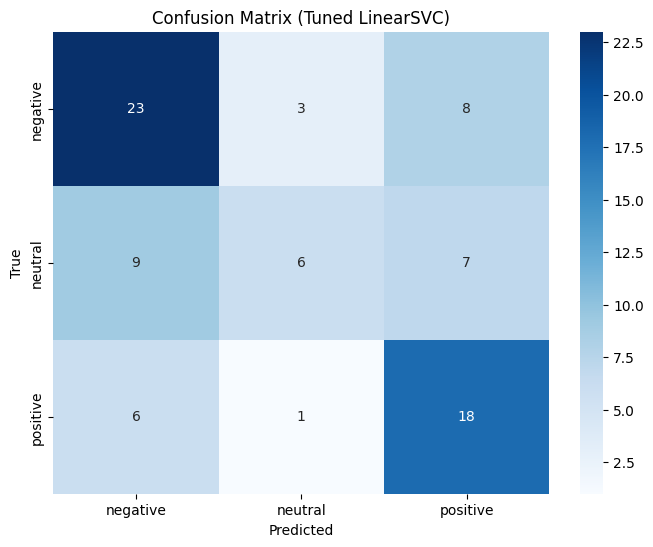

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

# Assuming X (TF-IDF features) and y (labels) are already defined

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
# It's important to consider 'dual=False' when using 'l1' penalty.
# LinearSVC with 'l1' penalty only supports 'squared_hinge' loss and requires dual=False
param_grid = [
    {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l2'], 'loss': ['hinge', 'squared_hinge'], 'class_weight': ['balanced', None]},
    {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1'], 'loss': ['squared_hinge'], 'dual': [False], 'class_weight': ['balanced', None]} # dual=False for l1 penalty
]


# Initialize GridSearchCV
# 'scoring' can be 'accuracy', 'f1_weighted', 'roc_auc' depending on your primary metric
# For imbalanced sentiment data, 'f1_weighted' or 'roc_auc' might be more informative than 'accuracy'.
# If the classes are reasonably balanced, accuracy is fine.
grid_search = GridSearchCV(
    LinearSVC(random_state=42, max_iter=2000), # Increased max_iter for stability
    param_grid,
    cv=5, # 5-fold cross-validation
    verbose=2, # More verbose output during search
    n_jobs=-1, # Use all available CPU cores
    scoring='f1_weighted' # Or 'accuracy', 'precision_weighted', 'recall_weighted'
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (e.g., F1-weighted):", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the untouched test data
y_pred_tuned = best_model.predict(X_test)

# Evaluate the tuned model
print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred_tuned))

print("\nConfusion Matrix (Tuned Model):")
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Tuned LinearSVC)')
plt.show()

📊 Classification Report:

              precision    recall  f1-score   support

    negative       0.72      0.76      0.74        17
     neutral       0.83      0.45      0.59        11
    positive       0.53      0.69      0.60        13

    accuracy                           0.66        41
   macro avg       0.69      0.64      0.64        41
weighted avg       0.69      0.66      0.66        41



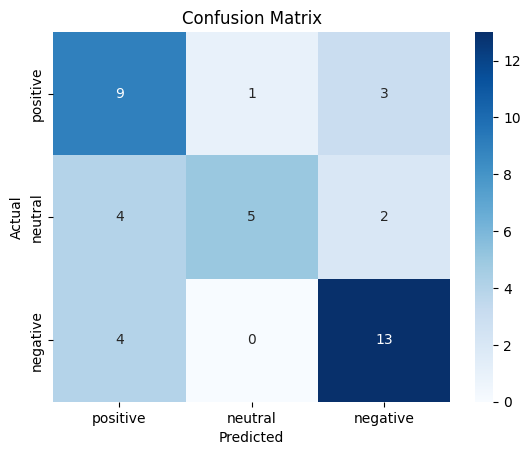

In [ ]:
# ===============================
# STEP 7: Evaluation
# ===============================
y_pred = model.predict(X_test)
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=['positive', 'neutral', 'negative'])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['positive', 'neutral', 'negative'],
            yticklabels=['positive', 'neutral', 'negative'], cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# ===============================
# STEP 10: OPTIONAL - Predict Unlabeled Data
# ===============================
try:
    df_unlabeled = pd.read_csv('x-data-all.csv', sep=';', encoding='ISO-8859-1')
    df_unlabeled = df_unlabeled.dropna(subset=['komentar'])
    df_unlabeled['clean_text'] = df_unlabeled['komentar'].apply(preprocess)
    X_unlabeled = vectorizer.transform(df_unlabeled['clean_text'])
    df_unlabeled['predicted_sentiment'] = model.predict(X_unlabeled)

    print("\n✅ Predicted Sentiment for Unlabeled Data:")
    print(df_unlabeled[['komentar', 'predicted_sentiment']].head())
    df_unlabeled.to_csv('predicted-unlabeled.csv', index=False)
except Exception as e:
    print("\n⚠️ No unlabeled data found or error occurred:", e)


⚠️ No unlabeled data found or error occurred: ['komentar']


# LINEAR SVC WITH GRIDSEARCH

--- Loading User's Actual Data (x-data-labeled.csv) ---

First 5 rows of the loaded and preprocessed DataFrame:
                                            komentar     label
0  @Filosofi_Kucing @tempodotco Tambah2an anak SD...  negative
1  @bunshin_ysf1 @tempodotco saya dari SMP bukan ...   neutral
2  @tempodotco Pelajaran AI coding dini penting? ...  positive
3  politikus gede bacot semua anj, kemaren kuriku...  negative
4  Kayak gini? Miris! Meja Gibran Cuma Penuh Main...  negative

Columns in the preprocessed DataFrame:
Index(['komentar', 'label'], dtype='object')

Initial DataFrame Label Counts (after preprocessing):
label
negative    185
positive    124
neutral      89
Name: count, dtype: int64
----------------------------------------

--- Vectorizing Text Data with TF-IDF ---
Shape of TF-IDF features (X): (398, 7000)
Shape of labels (y): (398,)
----------------------------------------

--- Splitting Data into Training and Test Sets ---
Original training set label counts:
label
n

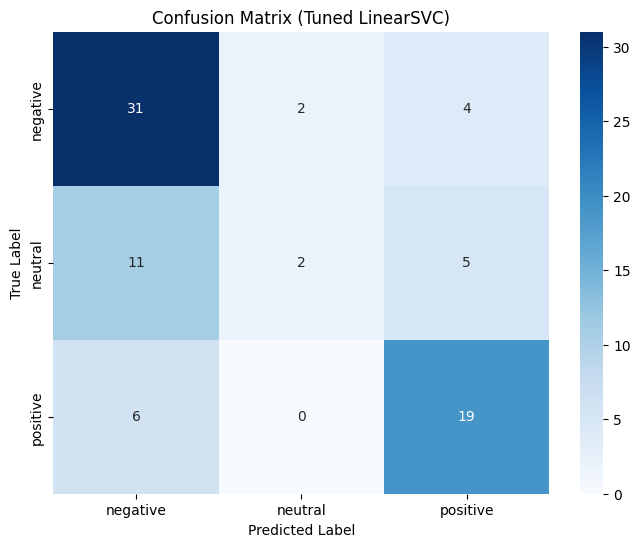


--- End of Model Training and Evaluation ---


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration for Column Names ---
# IMPORTANT: Adjust these variables to match the actual column names in your CSV file.
# Based on your provided code, the text column after renaming is 'komentar'
text_column_name = 'komentar'
# The label column is consistently 'label'
label_column_name = 'label'

# --- 1. Load User's Actual Data ---
print("--- Loading User's Actual Data (x-data-labeled.csv) ---")
try:
    # Assuming 'x-data-labeled.csv' uses ';' as a delimiter and 'ISO-8859-1' encoding.
    df = pd.read_csv('x-data-labeled.csv', sep=';', encoding='ISO-8859-1')

    # Apply the same renaming and filtering steps as in your provided code
    df = df[['ï»¿komentar', 'label']].dropna()
    df = df.rename(columns={'ï»¿komentar': 'komentar'})
    df = df[df['label'].isin(['positive', 'negative', 'neutral'])]

    # Display the first few rows and column names to help with debugging
    print("\nFirst 5 rows of the loaded and preprocessed DataFrame:")
    print(df.head())
    print("\nColumns in the preprocessed DataFrame:")
    print(df.columns)

    # Validate if the specified columns exist after preprocessing
    if text_column_name not in df.columns:
        raise KeyError(f"Error: Text column '{text_column_name}' not found in the DataFrame after preprocessing. Please check 'text_column_name' variable and preprocessing steps.")
    if label_column_name not in df.columns:
        raise KeyError(f"Error: Label column '{label_column_name}' not found in the DataFrame after preprocessing. Please check 'label_column_name' variable and preprocessing steps.")

except FileNotFoundError:
    print("Error: 'x-data-labeled.csv' not found. Please ensure the file is uploaded.")
    print("Execution halted. Please upload the file or correct the filename.")
    exit() # Exit if the file is not found
except KeyError as e:
    print(f"Error: {e}")
    print("Please update the 'text_column_name' and/or 'label_column_name' variables at the top of the code to match your CSV's actual column headers, or check your preprocessing steps.")
    print("Execution halted.")
    exit() # Exit if required columns are not found
except Exception as e:
    print(f"An unexpected error occurred during data loading or preprocessing: {e}")
    print("Execution halted.")
    exit()

print("\nInitial DataFrame Label Counts (after preprocessing):")
print(df[label_column_name].value_counts())
print("-" * 40)

# --- 2. Vectorize Text Data ---
print("\n--- Vectorizing Text Data with TF-IDF ---")
# Initialize TF-IDF Vectorizer with n-grams and max_features
# min_df and max_df can be tuned as well to filter out very rare or very common words
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=7000)

# Fit and transform the text column to get features (X)
X = tfidf.fit_transform(df[text_column_name])
# Get the labels (y)
y = df[label_column_name]

print(f"Shape of TF-IDF features (X): {X.shape}")
print(f"Shape of labels (y): {y.shape}")
print("-" * 40)

# --- 3. Split Data into Training and Testing Sets ---
print("\n--- Splitting Data into Training and Test Sets ---")
# Stratify ensures that the proportion of classes is maintained in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(f"Original training set label counts:\n{y_train.value_counts()}")
print(f"Original test set label counts:\n{y_test.value_counts()}")
print("-" * 40)

# --- 4. Apply SMOTE to the Training Data ONLY ---
print("\n--- Applying SMOTE to Training Data ---")
# SMOTE generates synthetic samples for minority classes to balance the dataset.
# 'auto' strategy oversamples all minority classes to match the number of samples
# in the majority class, or nearly so.
smote = SMOTE(random_state=42, sampling_strategy='auto')

# Fit and resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled training set label counts:\n{y_train_resampled.value_counts()}")
print(f"Shape of resampled training features (X_train_resampled): {X_train_resampled.shape}")
print("-" * 40)

# --- 5. Hyperparameter Tuning with GridSearchCV ---
print("\n--- Performing GridSearchCV for LinearSVC ---")
# Define the parameter grid for LinearSVC
# We include 'penalty', 'loss', 'C', and 'class_weight'.
# Note: 'dual=False' is required when penalty='l1'.
param_grid = [
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': ['l2'],
        'loss': ['hinge', 'squared_hinge'],
        'class_weight': ['balanced', None] # Let GridSearchCV decide if 'balanced' is always best
    },
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': ['l1'],
        'loss': ['squared_hinge'], # 'l1' penalty only supports 'squared_hinge' loss
        'dual': [False], # Must be False for 'l1' penalty
        'class_weight': ['balanced', None]
    }
]

# Initialize GridSearchCV
# cv=5 for 5-fold cross-validation
# verbose=2 for detailed output during the search
# n_jobs=-1 to use all available CPU cores for faster computation
# scoring='f1_weighted' is used because it's a good metric for imbalanced datasets
grid_search = GridSearchCV(
    LinearSVC(random_state=42, max_iter=2000), # Pass a base estimator instance
    param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1,
    scoring='f1_weighted'
)

# Fit GridSearchCV on the SMOTE-resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)
print("\nBest cross-validation score (F1-weighted):")
print(grid_search.best_score_)
print("-" * 40)

# --- 6. Evaluate the Best Model on the Untouched Test Data ---
print("\n--- Evaluating the Best Model on the Test Set ---")
best_model = grid_search.best_estimator_

# Make predictions on the original, untouched test set
y_pred = best_model.predict(X_test)

# Print classification report
print("\nClassification Report (Best Tuned LinearSVC Model):")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
print("\nConfusion Matrix (Best Tuned LinearSVC Model):")
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_) # Ensure labels are in consistent order
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Tuned LinearSVC)')
plt.show()

print("\n--- End of Model Training and Evaluation ---")


--- Loading User's Actual Data (x-data-labeled.csv) ---

First 5 rows of the loaded and preprocessed DataFrame:
                                            komentar     label
0  @Filosofi_Kucing @tempodotco Tambah2an anak SD...  negative
1  @bunshin_ysf1 @tempodotco saya dari SMP bukan ...   neutral
2  @tempodotco Pelajaran AI coding dini penting? ...  positive
3  politikus gede bacot semua anj, kemaren kuriku...  negative
4  Kayak gini? Miris! Meja Gibran Cuma Penuh Main...  negative

Columns in the preprocessed DataFrame:
Index(['komentar', 'label'], dtype='object')

Initial DataFrame Label Counts (after preprocessing):
label
negative    185
positive    124
neutral      89
Name: count, dtype: int64
----------------------------------------

--- Vectorizing Text Data with TF-IDF ---
Shape of TF-IDF features (X): (398, 436)
Shape of labels (y): (398,)
----------------------------------------

--- Splitting Data into Training and Test Sets ---
Original training set label counts:
label
ne

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


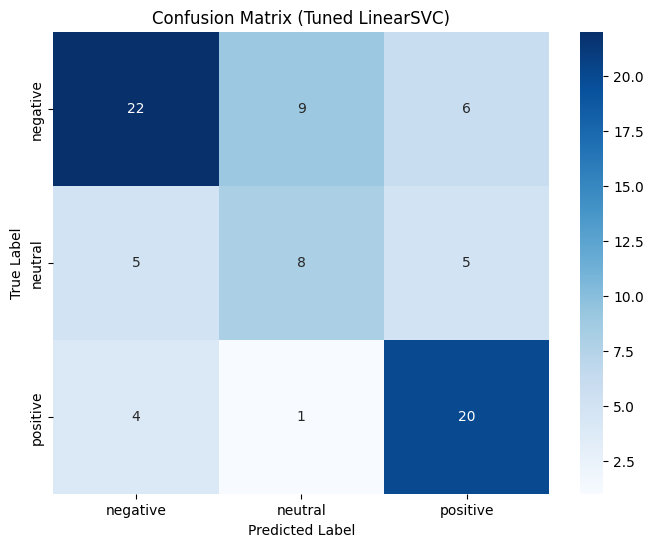


--- End of Model Training and Evaluation ---


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration for Column Names ---
# IMPORTANT: Adjust these variables to match the actual column names in your CSV file.
# Based on your provided code, the text column after renaming is 'komentar'
text_column_name = 'komentar'
# The label column is consistently 'label'
label_column_name = 'label'

# --- 1. Load User's Actual Data ---
print("--- Loading User's Actual Data (x-data-labeled.csv) ---")
try:
    # Assuming 'x-data-labeled.csv' uses ';' as a delimiter and 'ISO-8859-1' encoding.
    df = pd.read_csv('x-data-labeled.csv', sep=';', encoding='ISO-8859-1')

    # Apply the same renaming and filtering steps as in your provided code
    df = df[['ï»¿komentar', 'label']].dropna()
    df = df.rename(columns={'ï»¿komentar': 'komentar'})
    df = df[df['label'].isin(['positive', 'negative', 'neutral'])]

    # Display the first few rows and column names to help with debugging
    print("\nFirst 5 rows of the loaded and preprocessed DataFrame:")
    print(df.head())
    print("\nColumns in the preprocessed DataFrame:")
    print(df.columns)

    # Validate if the specified columns exist after preprocessing
    if text_column_name not in df.columns:
        raise KeyError(f"Error: Text column '{text_column_name}' not found in the DataFrame after preprocessing. Please check 'text_column_name' variable and preprocessing steps.")
    if label_column_name not in df.columns:
        raise KeyError(f"Error: Label column '{label_column_name}' not found in the DataFrame after preprocessing. Please check 'label_column_name' variable and preprocessing steps.")

except FileNotFoundError:
    print("Error: 'x-data-labeled.csv' not found. Please ensure the file is uploaded.")
    print("Execution halted. Please upload the file or correct the filename.")
    exit() # Exit if the file is not found
except KeyError as e:
    print(f"Error: {e}")
    print("Please update the 'text_column_name' and/or 'label_column_name' variables at the top of the code to match your CSV's actual column headers, or check your preprocessing steps.")
    print("Execution halted.")
    exit() # Exit if required columns are not found
except Exception as e:
    print(f"An unexpected error occurred during data loading or preprocessing: {e}")
    print("Execution halted.")
    exit()

print("\nInitial DataFrame Label Counts (after preprocessing):")
print(df[label_column_name].value_counts())
print("-" * 40)

# --- 2. Vectorize Text Data ---
print("\n--- Vectorizing Text Data with TF-IDF ---")
# Initialize TF-IDF Vectorizer with n-grams and max_features
# IMPORTANT: Added min_df and max_df for further feature filtering.
# min_df=5: Ignores terms that appear in less than 5 documents (removes very rare words/noise).
# max_df=0.8: Ignores terms that appear in more than 80% of the documents (removes very common words, like potential domain-specific stopwords).
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=7000, min_df=5, max_df=0.8)

# Fit and transform the text column to get features (X)
X = tfidf.fit_transform(df[text_column_name])
# Get the labels (y)
y = df[label_column_name]

print(f"Shape of TF-IDF features (X): {X.shape}")
print(f"Shape of labels (y): {y.shape}")
print("-" * 40)

# --- 3. Split Data into Training and Testing Sets ---
print("\n--- Splitting Data into Training and Test Sets ---")
# Stratify ensures that the proportion of classes is maintained in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(f"Original training set label counts:\n{y_train.value_counts()}")
print(f"Original test set label counts:\n{y_test.value_counts()}")
print("-" * 40)

# --- 4. Apply SMOTE to the Training Data ONLY ---
print("\n--- Applying SMOTE to Training Data ---")
# SMOTE generates synthetic samples for minority classes to balance the dataset.
# 'auto' strategy oversamples all minority classes to match the number of samples
# in the majority class, or nearly so.
smote = SMOTE(random_state=42, sampling_strategy='auto')

# Fit and resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled training set label counts:\n{y_train_resampled.value_counts()}")
print(f"Shape of resampled training features (X_train_resampled): {X_train_resampled.shape}")
print("-" * 40)

# --- 5. Hyperparameter Tuning with GridSearchCV ---
print("\n--- Performing GridSearchCV for LinearSVC ---")
# Define the parameter grid for LinearSVC
# We include 'penalty', 'loss', 'C', and 'class_weight'.
# Note: 'dual=False' is required when penalty='l1'.
param_grid = [
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': ['l2'],
        'loss': ['hinge', 'squared_hinge'],
        'class_weight': ['balanced', None] # Let GridSearchCV decide if 'balanced' is always best
    },
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': ['l1'],
        'loss': ['squared_hinge'], # 'l1' penalty only supports 'squared_hinge' loss
        'dual': [False], # Must be False for 'l1' penalty
        'class_weight': ['balanced', None]
    }
]

# Initialize GridSearchCV
# cv=5 for 5-fold cross-validation
# verbose=2 for detailed output during the search
# n_jobs=-1 to use all available CPU cores for faster computation
# scoring='f1_weighted' is used because it's a good metric for imbalanced datasets
grid_search = GridSearchCV(
    LinearSVC(random_state=42, max_iter=2000), # Pass a base estimator instance
    param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1,
    scoring='f1_weighted'
)

# Fit GridSearchCV on the SMOTE-resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)
print("\nBest cross-validation score (F1-weighted):")
print(grid_search.best_score_)
print("-" * 40)

# --- 6. Evaluate the Best Model on the Untouched Test Data ---
print("\n--- Evaluating the Best Model on the Test Set ---")
best_model = grid_search.best_estimator_

# Make predictions on the original, untouched test set
y_pred = best_model.predict(X_test)

# Print classification report
print("\nClassification Report (Best Tuned LinearSVC Model):")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
print("\nConfusion Matrix (Best Tuned LinearSVC Model):")
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_) # Ensure labels are in consistent order
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Tuned LinearSVC)')
plt.show()

print("\n--- End of Model Training and Evaluation ---")


# Multillineal Naive Bayes

--- Loading User's Actual Data (x-data-labeled.csv) ---

First 5 rows of the loaded and preprocessed DataFrame:
                                            komentar     label
0  @Filosofi_Kucing @tempodotco Tambah2an anak SD...  negative
1  @bunshin_ysf1 @tempodotco saya dari SMP bukan ...   neutral
2  @tempodotco Pelajaran AI coding dini penting? ...  positive
3  politikus gede bacot semua anj, kemaren kuriku...  negative
4  Kayak gini? Miris! Meja Gibran Cuma Penuh Main...  negative

Columns in the preprocessed DataFrame:
Index(['komentar', 'label'], dtype='object')

Initial DataFrame Label Counts (after preprocessing):
label
negative    172
positive    124
neutral     109
Name: count, dtype: int64
----------------------------------------

--- Applying Custom Text Preprocessing ---

Sample of preprocessed text (df['clean_text'].head()):
0    tambah2an anak kelas bisa coding benerin kurik...
1    smp hafal provinsi ibukota provinsi indo hafal...
2    ajar coding attitude disiplin tang

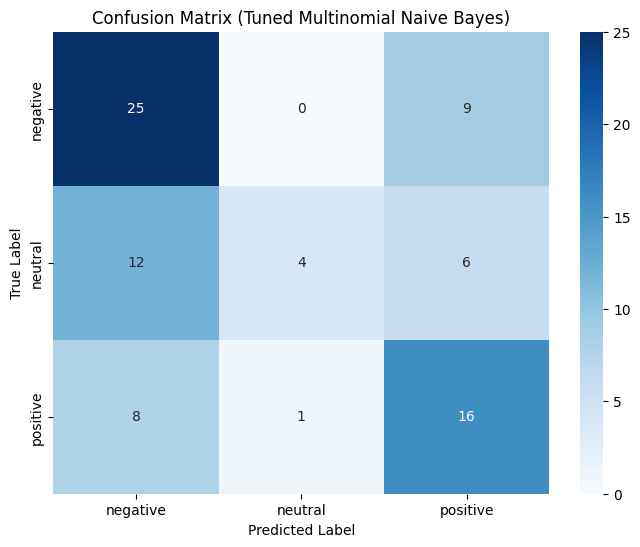


--- Attempting Threshold Adjustment for 'Neutral' Class ---

Classification Report (MNB with Neutral Threshold=0.05):
              precision    recall  f1-score   support

    negative       0.67      0.29      0.41        34
     neutral       0.35      0.77      0.49        22
    positive       0.50      0.36      0.42        25

    accuracy                           0.44        81
   macro avg       0.51      0.48      0.44        81
weighted avg       0.53      0.44      0.43        81


Confusion Matrix (MNB with Neutral Threshold=0.05):


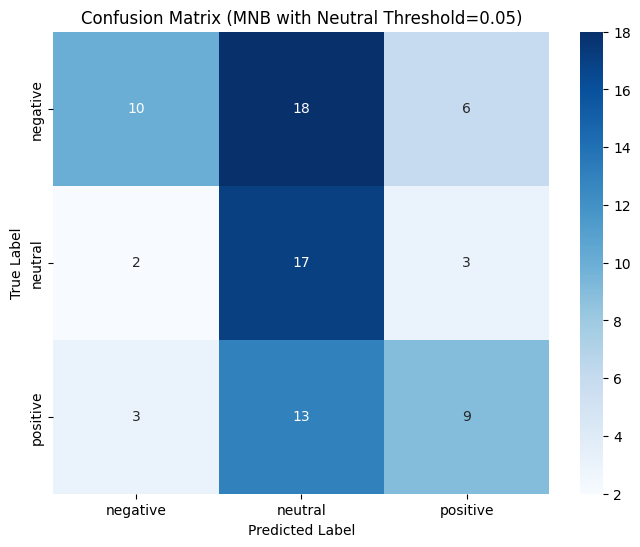


Classification Report (MNB with Neutral Threshold=0.1):
              precision    recall  f1-score   support

    negative       0.60      0.44      0.51        34
     neutral       0.39      0.55      0.45        22
    positive       0.48      0.48      0.48        25

    accuracy                           0.48        81
   macro avg       0.49      0.49      0.48        81
weighted avg       0.51      0.48      0.48        81


Confusion Matrix (MNB with Neutral Threshold=0.1):


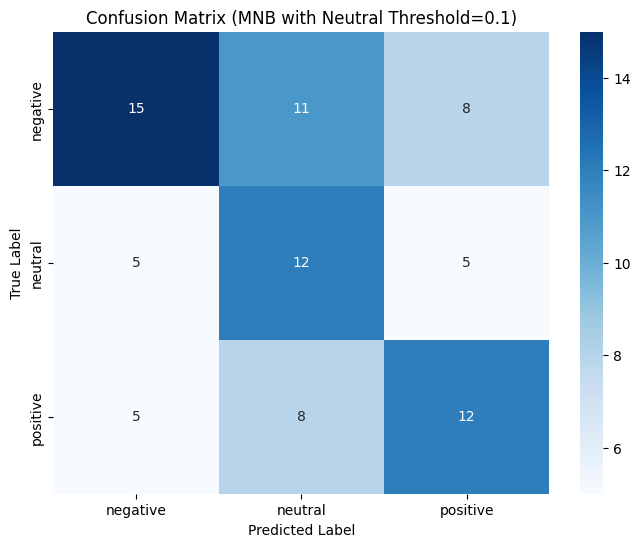


Classification Report (MNB with Neutral Threshold=0.15):
              precision    recall  f1-score   support

    negative       0.57      0.47      0.52        34
     neutral       0.37      0.45      0.41        22
    positive       0.46      0.48      0.47        25

    accuracy                           0.47        81
   macro avg       0.47      0.47      0.46        81
weighted avg       0.48      0.47      0.47        81


Confusion Matrix (MNB with Neutral Threshold=0.15):


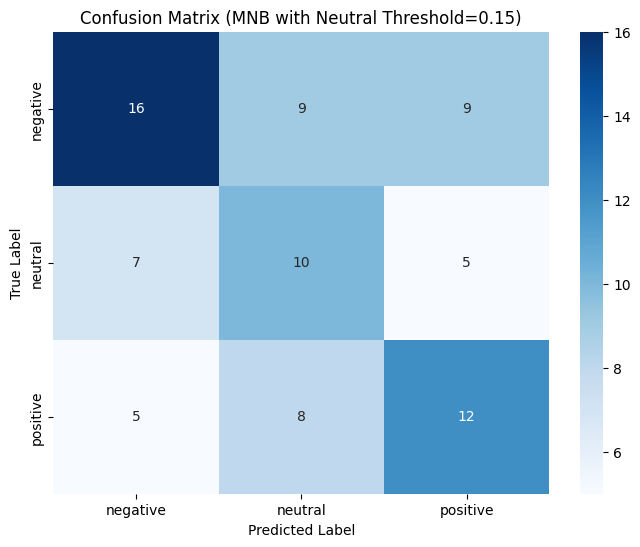


Classification Report (MNB with Neutral Threshold=0.2):
              precision    recall  f1-score   support

    negative       0.57      0.59      0.58        34
     neutral       0.56      0.41      0.47        22
    positive       0.53      0.64      0.58        25

    accuracy                           0.56        81
   macro avg       0.56      0.55      0.55        81
weighted avg       0.56      0.56      0.55        81


Confusion Matrix (MNB with Neutral Threshold=0.2):


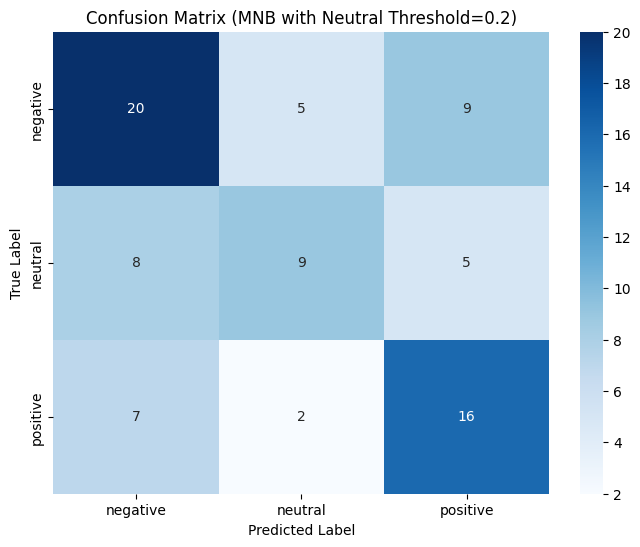


Classification Report (MNB with Neutral Threshold=0.25):
              precision    recall  f1-score   support

    negative       0.58      0.65      0.61        34
     neutral       0.62      0.36      0.46        22
    positive       0.53      0.64      0.58        25

    accuracy                           0.57        81
   macro avg       0.58      0.55      0.55        81
weighted avg       0.57      0.57      0.56        81


Confusion Matrix (MNB with Neutral Threshold=0.25):


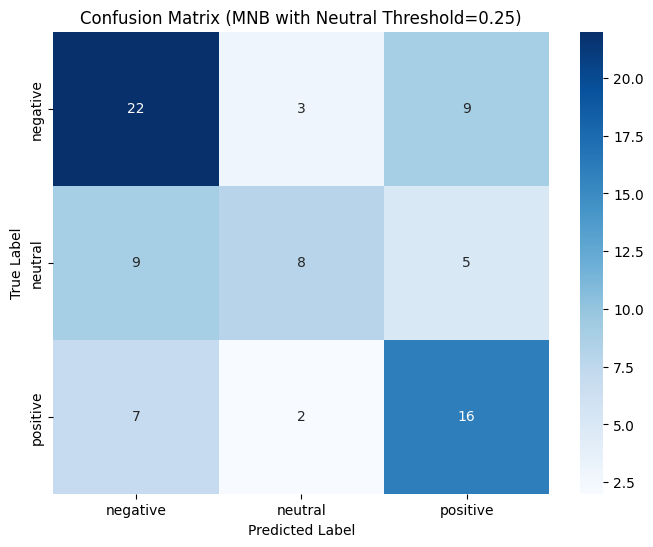


Classification Report (MNB with Neutral Threshold=0.3):
              precision    recall  f1-score   support

    negative       0.61      0.74      0.67        34
     neutral       0.78      0.32      0.45        22
    positive       0.52      0.64      0.57        25

    accuracy                           0.59        81
   macro avg       0.63      0.56      0.56        81
weighted avg       0.63      0.59      0.58        81


Confusion Matrix (MNB with Neutral Threshold=0.3):


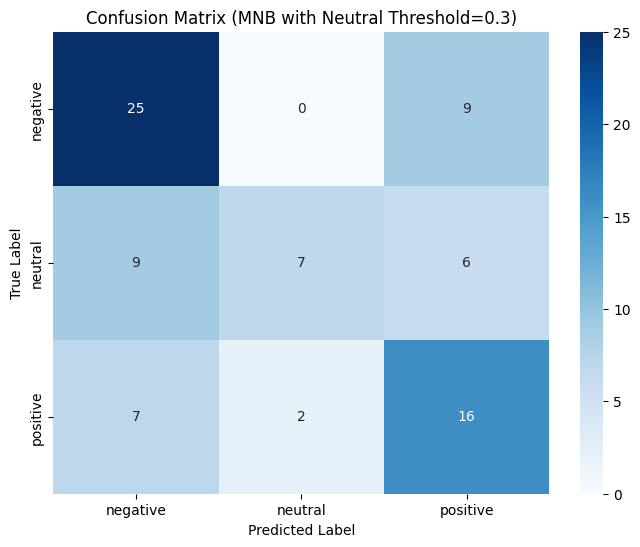


Classification Report (MNB with Neutral Threshold=0.35):
              precision    recall  f1-score   support

    negative       0.56      0.74      0.63        34
     neutral       0.80      0.18      0.30        22
    positive       0.52      0.64      0.57        25

    accuracy                           0.56        81
   macro avg       0.62      0.52      0.50        81
weighted avg       0.61      0.56      0.52        81


Confusion Matrix (MNB with Neutral Threshold=0.35):


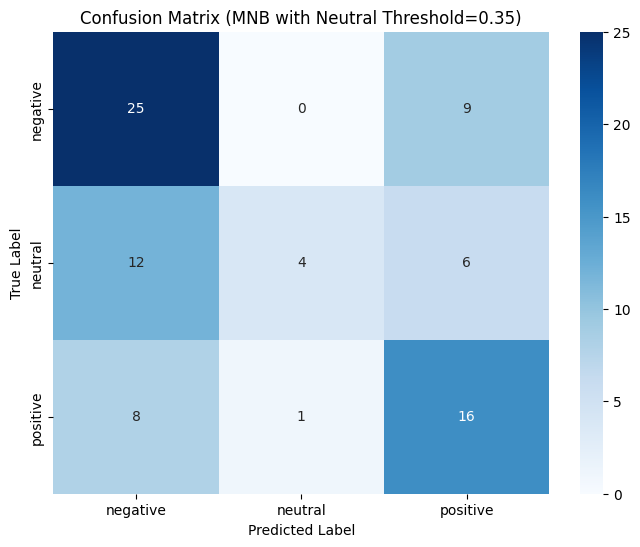


Classification Report (MNB with Neutral Threshold=0.4):
              precision    recall  f1-score   support

    negative       0.56      0.74      0.63        34
     neutral       0.80      0.18      0.30        22
    positive       0.52      0.64      0.57        25

    accuracy                           0.56        81
   macro avg       0.62      0.52      0.50        81
weighted avg       0.61      0.56      0.52        81


Confusion Matrix (MNB with Neutral Threshold=0.4):


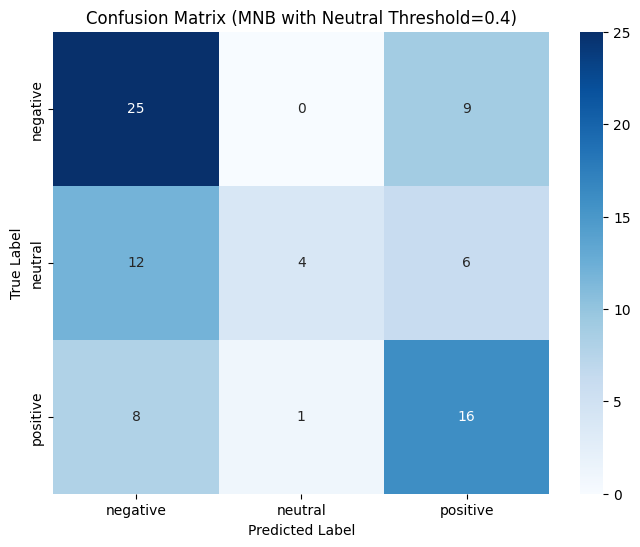


--- End of Model Training and Evaluation ---


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Ensure NLTK stopwords are downloaded
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
    print("NLTK stopwords downloaded.")


# --- Configuration for Column Names ---
text_column_name = 'komentar'
label_column_name = 'label'

# --- 1. Load User's Actual Data ---
print("--- Loading User's Actual Data (x-data-labeled.csv) ---")
try:
    df = pd.read_csv('x-data-labeled.csv', sep=';', encoding='ISO-8859-1')
    df = df[['ï»¿komentar', 'label']].dropna()
    df = df.rename(columns={'ï»¿komentar': 'komentar'})
    df = df[df['label'].isin(['positive', 'negative', 'neutral'])]

    print("\nFirst 5 rows of the loaded and preprocessed DataFrame:")
    print(df.head())
    print("\nColumns in the preprocessed DataFrame:")
    print(df.columns)

    if text_column_name not in df.columns:
        raise KeyError(f"Error: Text column '{text_column_name}' not found in the DataFrame after preprocessing. Please check 'text_column_name' variable and preprocessing steps.")
    if label_column_name not in df.columns:
        raise KeyError(f"Error: Label column '{label_column_name}' not found in the DataFrame after preprocessing. Please check 'label_column_name' variable and preprocessing steps.")

except FileNotFoundError:
    print("Error: 'x-data-labeled.csv' not found. Please ensure the file is uploaded.")
    print("Execution halted. Please upload the file or correct the filename.")
    exit()
except KeyError as e:
    print(f"Error: {e}")
    print("Please update the 'text_column_name' and/or 'label_column_name' variables at the top of the code to match your CSV's actual column headers, or check your preprocessing steps.")
    print("Execution halted.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during data loading or preprocessing: {e}")
    print("Execution halted.")
    exit()

print("\nInitial DataFrame Label Counts (after preprocessing):")
print(df[label_column_name].value_counts())
print("-" * 40)


# --- STEP 4: Preprocessing Functions ---
print("\n--- Applying Custom Text Preprocessing ---")

stop_words = set(stopwords.words('indonesian'))
stemmer = StemmerFactory().create_stemmer()

slang_dict = {
    'ga': 'tidak', 'gak': 'tidak', 'nggak': 'tidak', 'ngga': 'tidak',
    'banget': 'sangat', 'bgt': 'sangat', 'kalo': 'kalau', 'gitu': 'begitu',
    'aja': 'saja', 'loh': '', 'deh': '', 'mah': '', 'dah': '', 'cuy': '',
    'anj': 'kasar', 'wkwk': '', 'lol': '', 'btw': '', 'sm': 'sama',
    'pdhl': 'padahal', 'tp': 'tapi', 'sy': 'saya', 'gw': 'saya', 'gue': 'saya',
    'udh': 'sudah', 'sdh': 'sudah', 'dr': 'dari', 'tdk': 'tidak', 'td': 'tidak', 'tambah2':'tambah-tambah','gin':'gini'
}

emoji_dict = {
    '😡':'negatif', '😢':'negatif', '😭':'negatif', '🤬':'negatif',
    '😍':'positif', '😊':'positif', '😂':'positif', '👍':'positif', '🙏':'positif'
}

sarcasm_markers = ['banget ya', 'hebat banget', 'ndasmu', 'pintar sekali ya']

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"(.)\1{2,}", r"\1", text)
    text = text.strip()
    return text

def preprocess(text):
    text = clean_text(text)
    for word, replacement in slang_dict.items():
        text = re.sub(r'\b' + re.escape(word) + r'\b', replacement, text)
    for emo, label in emoji_dict.items():
        text = text.replace(emo, label)
    tokens = text.split()
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words and len(t) > 2]
    for marker in sarcasm_markers:
        if marker in text:
            tokens.append("sarcasm")
    return ' '.join(tokens)

df['clean_text'] = df[text_column_name].apply(preprocess)

print("\nSample of preprocessed text (df['clean_text'].head()):")
print(df['clean_text'].head())
print("-" * 40)

# --- 2. Vectorize Text Data (using the new 'clean_text' column) ---
print("\n--- Vectorizing Text Data with TF-IDF ---")
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=7000)

X = tfidf.fit_transform(df['clean_text'])
y = df[label_column_name]

print(f"Shape of TF-IDF features (X): {X.shape}")
print(f"Shape of labels (y): {y.shape}")
print("-" * 40)

# --- 3. Split Data into Training and Testing Sets ---
print("\n--- Splitting Data into Training and Test Sets ---")
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(f"Original training set label counts:\n{y_train.value_counts()}")
print(f"Original test set label counts:\n{y_test.value_counts()}")
print("-" * 40)

# --- 4. Apply SMOTE to the Training Data ONLY ---
print("\n--- Applying SMOTE to Training Data ---")
# Using BorderlineSMOTE instead of basic SMOTE for potentially better synthetic sample generation
# Based on original training counts: negative=148, positive=99, neutral=71
# We will oversample negative and positive to match the training set's initial majority (negative: 148)
# and then oversample neutral to a higher number (e.g., 250) to give it more weight.
smote = BorderlineSMOTE(random_state=42, sampling_strategy={'negative': 148, 'positive': 148, 'neutral': 250})


X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled training set label counts:\n{y_train_resampled.value_counts()}")
print(f"Shape of resampled training features (X_train_resampled): {X_train_resampled.shape}")
print("-" * 40)

# --- 5. Hyperparameter Tuning with GridSearchCV ---
print("\n--- Performing GridSearchCV for MultinomialNB ---")
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]
}

grid_search = GridSearchCV(
    MultinomialNB(),
    param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1,
    scoring='f1_weighted'
)

grid_search.fit(X_train_resampled, y_train_resampled)

print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)
print("\nBest cross-validation score (F1-weighted):")
print(grid_search.best_score_)
print("-" * 40)

# --- 6. Evaluate the Best Model on the Untouched Test Data ---
print("\n--- Evaluating the Best Model on the Test Set ---")
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("\nClassification Report (Best Tuned Multinomial Naive Bayes Model):")
print(classification_report(y_test, y_pred, zero_division=0)) # Added zero_division to avoid warnings

print("\nConfusion Matrix (Best Tuned Multinomial Naive Bayes Model):")
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Tuned Multinomial Naive Bayes)')
plt.show()

# --- 7. Attempt Threshold Adjustment for 'Neutral' Class ---
print("\n--- Attempting Threshold Adjustment for 'Neutral' Class ---")

# Get class probabilities for the test set
y_proba = best_model.predict_proba(X_test)

# Get the index for the 'neutral' class dynamically
# This handles cases where class order might change
try:
    neutral_class_idx = np.where(best_model.classes_ == 'neutral')[0][0]
except IndexError:
    print("Error: 'neutral' class not found in model's learned classes. Cannot perform threshold adjustment.")
    neutral_class_idx = -1 # Sentinel value to prevent further errors

if neutral_class_idx != -1:
    # Define a custom threshold for the 'neutral' class.
    # This value needs to be TUNED. Start with a low value like 0.1 or 0.2.
    # We will try a range of values here.
    neutral_thresholds_to_try = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4] # Example thresholds

    for neutral_threshold in neutral_thresholds_to_try:
        y_pred_thresholded = []
        for i in range(len(y_proba)):
            if y_proba[i, neutral_class_idx] >= neutral_threshold:
                y_pred_thresholded.append('neutral')
            else:
                # Predict the class with the highest probability among others
                # excluding the 'neutral' class if it didn't meet the threshold
                temp_proba = np.copy(y_proba[i])
                temp_proba[neutral_class_idx] = -1 # Set neutral prob to a very low value so argmax picks another class
                original_pred_idx = np.argmax(temp_proba)
                y_pred_thresholded.append(best_model.classes_[original_pred_idx])

        print(f"\nClassification Report (MNB with Neutral Threshold={neutral_threshold}):")
        print(classification_report(y_test, y_pred_thresholded, zero_division=0))

        print(f"\nConfusion Matrix (MNB with Neutral Threshold={neutral_threshold}):")
        cm_thresholded = confusion_matrix(y_test, y_pred_thresholded, labels=best_model.classes_)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_thresholded, annot=True, fmt='d', cmap='Blues',
                    xticklabels=best_model.classes_, yticklabels=best_model.classes_)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix (MNB with Neutral Threshold={neutral_threshold})')
        plt.show()
else:
    print("Skipping threshold adjustment as 'neutral' class not found in model's classes.")

print("\n--- End of Model Training and Evaluation ---")


--- Initializing and Re-training Model and TF-IDF Vectorizer ---
Multinomial Naive Bayes model re-trained successfully.
----------------------------------------

--- Loading New Dataset (x-data-all.csv) ---
Loaded new dataset with 165 entries.

First 5 rows of the new raw DataFrame:
                                            komentar  label
0  @IndoPopBase Ratain dulu kualitas sekolah di p...    NaN
1  untuk apa sebenarnya ? Untuk menyelesaikan soa...    NaN
2   kalau mau masukin pelajaran AI untuk kelas se...    NaN
3   padahal dasar semua program Algorthm dan Jari...    NaN
4  @IndoPopBase pelajaran AI : Maksud nya gmn? \n...    NaN
----------------------------------------

--- Applying Custom Text Preprocessing to New Data ---

Sample of preprocessed text from new data (new_df['clean_text'].head()):
0    ratain kualitas sekolah pelosok pastiin komput...
1            selesai matematika dasar orang anak bodoh
2    masukin ajar kelas sekolah smu smkkejuruan sek...
3    dasar program a

/tmp/ipython-input-6-719500083.py:196: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='predicted_label', data=new_df, order=new_df['predicted_label'].value_counts().index, palette='viridis')


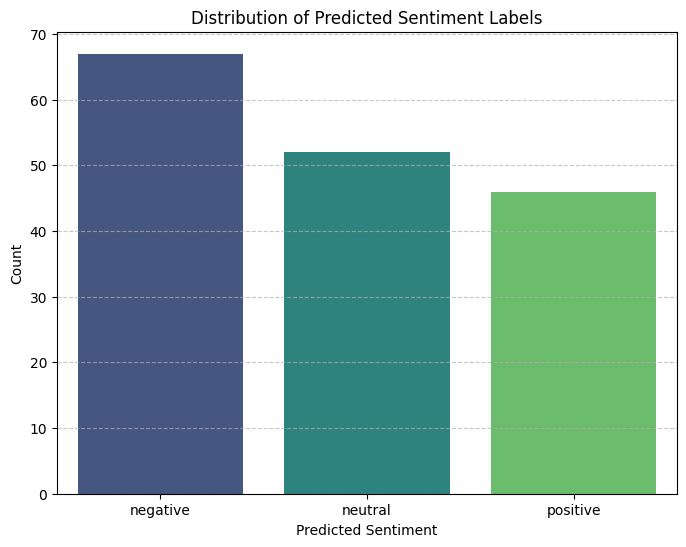

----------------------------------------

--- Generating Word Cloud from All Preprocessed Text ---


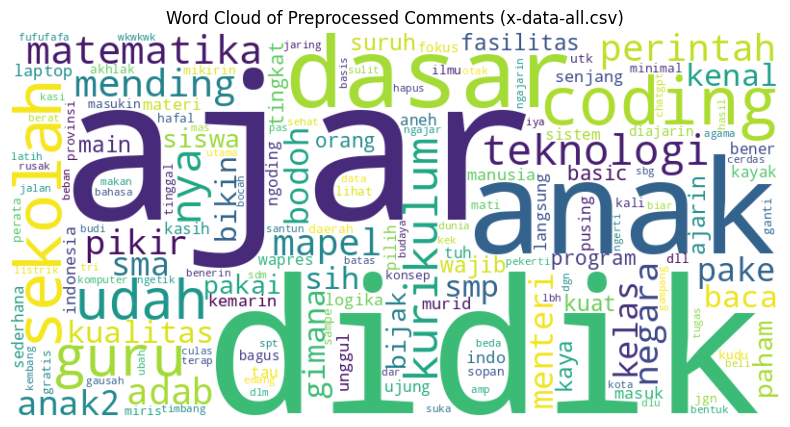

----------------------------------------

--- Showing Sample Comments for Each Predicted Sentiment ---

--- Sample 'negative' Comments ---
1. @IndoPopBase Ratain dulu kualitas sekolah di pelosok pastiin semuanya ada komputer, baru ngomong AI 
Tapi kepikiran sampe sini ga? Awkwkwkwk

Lagian kurikulum AI apa sih? Bikin prompt??? Tailah
2. untuk apa sebenarnya ? Untuk menyelesaikan soal matematika dasar ? Tidak semua orang mau anaknya bodoh seperti anda
3.  kalau mau masukin pelajaran AI untuk kelas sekolah umum (smu) dan  di SMK(kejuruan).

sekolah dasar =| cukup matematika pedoman dan pondasi dasar dr semua basis Teknologi . 
kalau sekedar pengenalan definisi diSMP.
4.  padahal dasar semua program Algorthm dan Jaringan AI mencangkup nilai dasar Matematika dan terusanya (Lain2nya).
kombinasi code(Software)/chip/server/sinkronisasi/Modal/etc. 
Wapresnya? berlebihan menyikapi Trend . 

lagian kalau sadar diri seharusnya enga usah nyapres
5. @IndoPopBase Belajar AI nya pakai Pensil 2B atau 

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split # Needed for re-training setup
from imblearn.over_sampling import ADASYN # Needed for re-training setup
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Ensure NLTK stopwords are downloaded
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
    print("NLTK stopwords downloaded.")

# --- Configuration (must match training pipeline for consistent prediction) ---
text_column_name = 'komentar'
label_column_name = 'label' # For original labeled data
TFIDF_MAX_FEATURES = 7000
MNB_BEST_ALPHA = 0.01 # Best alpha from your GridSearchCV
NEUTRAL_THRESHOLD = 0.3 # Your chosen best threshold for 'neutral'
ADASYN_SAMPLING_STRATEGY = {'negative': 148, 'positive': 148, 'neutral': 250} # ADASYN strategy used in training

# --- Preprocessing Components (identical to training) ---
stop_words = set(stopwords.words('indonesian'))
stemmer = StemmerFactory().create_stemmer()

slang_dict = {
    'ga': 'tidak', 'gak': 'tidak', 'nggak': 'tidak', 'ngga': 'tidak',
    'banget': 'sangat', 'bgt': 'sangat', 'kalo': 'kalau', 'gitu': 'begitu',
    'aja': 'saja', 'loh': '', 'deh': '', 'mah': '', 'dah': '', 'cuy': '',
    'anj': 'kasar', 'wkwk': '', 'lol': '', 'btw': '', 'sm': 'sama',
    'pdhl': 'padahal', 'tp': 'tapi', 'sy': 'saya', 'gw': 'saya', 'gue': 'saya',
    'udh': 'sudah', 'sdh': 'sudah', 'dr': 'dari', 'tdk': 'tidak', 'td': 'tidak', 'tambah2':'tambah-tambah','gin':'gini','gmn':'gimana'
}

emoji_dict = {
    '😡':'negatif', '😢':'negatif', '😭':'negatif', '🤬':'negatif',
    '😍':'positif', '😊':'positif', '😂':'positif', '👍':'positif', '🙏':'positif'
}

sarcasm_markers = ['banget ya', 'hebat banget', 'ndasmu', 'pintar sekali ya']

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"(.)\1{2,}", r"\1", text)
    text = text.strip()
    return text

def preprocess(text):
    text = clean_text(text)
    for word, replacement in slang_dict.items():
        text = re.sub(r'\b' + re.escape(word) + r'\b', replacement, text)
    for emo, label in emoji_dict.items():
        text = text.replace(emo, label)
    tokens = text.split()
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words and len(t) > 2]
    for marker in sarcasm_markers:
        if marker in text:
            tokens.append("sarcasm")
    return ' '.join(tokens)


# --- Re-train Model and Fit TF-IDF Vectorizer (for consistent prediction) ---
print("--- Initializing and Re-training Model and TF-IDF Vectorizer ---")
# Initialize global variables to ensure they are always defined
tfidf_vectorizer = None
best_model = None
model_classes = []
neutral_class_idx = -1

try:
    # Load original labeled data to fit TF-IDF and train the model
    df_original_labeled = pd.read_csv('x-data-labeled.csv', sep=';', encoding='ISO-8859-1')
    df_original_labeled = df_original_labeled[['ï»¿komentar', 'label']].dropna()
    df_original_labeled = df_original_labeled.rename(columns={'ï»¿komentar': 'komentar'})
    df_original_labeled = df_original_labeled[df_original_labeled['label'].isin(['positive', 'negative', 'neutral'])]
    df_original_labeled['clean_text'] = df_original_labeled['komentar'].apply(preprocess)

    # Fit TF-IDF on the original labeled data's clean text
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=TFIDF_MAX_FEATURES)
    X_original = tfidf_vectorizer.fit_transform(df_original_labeled['clean_text'])
    y_original = df_original_labeled[label_column_name]

    # Split to get the same training set (important for ADASYN consistency)
    X_train_re, _, y_train_re, _ = train_test_split(X_original, y_original, stratify=y_original, test_size=0.2, random_state=42)

    # Apply ADASYN with n_neighbors=1 for robustness with sparse data
    smote_re = ADASYN(random_state=42, sampling_strategy=ADASYN_SAMPLING_STRATEGY, n_neighbors=1)
    X_train_resampled_re, y_train_resampled_re = smote_re.fit_resample(X_train_re, y_train_re)

    # Fit the best model (MultinomialNB) on the resampled data
    best_model = MultinomialNB(alpha=MNB_BEST_ALPHA)
    best_model.fit(X_train_resampled_re, y_train_resampled_re)
    print("Multinomial Naive Bayes model re-trained successfully.")

    # Get class labels in the order the model learned them
    model_classes = best_model.classes_
    try:
        neutral_class_idx = np.where(model_classes == 'neutral')[0][0] # Get index of neutral class
    except IndexError:
        print("Warning: 'neutral' class not found in model's learned classes during retraining. Neutral thresholding might not work as expected.")
        neutral_class_idx = -1

except Exception as e:
    print(f"Error during model re-training/TF-IDF re-fitting: {e}")
    print("Prediction pipeline cannot proceed without a trained model and fitted vectorizer.")
    exit()
print("-" * 40)


# --- 1. Load the New Dataset (x-data-all.csv) ---
print("\n--- Loading New Dataset (x-data-all.csv) ---")
try:
    new_df = pd.read_csv('x-data-all.csv', sep=';', encoding='ISO-8859-1')
    new_df = new_df.rename(columns={'ï»¿komentar': 'komentar'})
    # Drop rows with NaN values specifically in the 'komentar' column
    new_df = new_df.dropna(subset=['komentar'])
    if 'komentar' not in new_df.columns:
        raise KeyError("Error: 'komentar' column not found in x-data-all.csv after renaming. Please check column names.")

except FileNotFoundError:
    print("Error: 'x-data-all.csv' not found. Please ensure the file is uploaded.")
    print("Execution halted.")
    exit()
except KeyError as e:
    print(f"Error: {e}")
    print("Please ensure the text column in 'x-data-all.csv' is correctly specified.")
    print("Execution halted.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during data loading: {e}")
    print("Execution halted.")
    exit()

print(f"Loaded new dataset with {len(new_df)} entries.")
print("\nFirst 5 rows of the new raw DataFrame:")
print(new_df.head())
print("-" * 40)

# --- 2. Apply Preprocessing to New Data ---
print("\n--- Applying Custom Text Preprocessing to New Data ---")
# Convert 'komentar' column to string type and fill NaN with empty strings
new_df['komentar'] = new_df['komentar'].astype(str).fillna('')
new_df['clean_text'] = new_df['komentar'].apply(preprocess)
print("\nSample of preprocessed text from new data (new_df['clean_text'].head()):")
print(new_df['clean_text'].head())
print("-" * 40)

# --- 3. Transform New Data using the *FITTED* TF-IDF Vectorizer ---
print("\n--- Vectorizing New Data ---")
# Ensure tfidf_vectorizer is fitted before transforming
if tfidf_vectorizer is None:
    print("Error: TF-IDF vectorizer was not successfully fitted. Cannot vectorize new data.")
    exit()
X_new_data = tfidf_vectorizer.transform(new_df['clean_text'])
print(f"Shape of vectorized new data (X_new_data): {X_new_data.shape}")
print("-" * 40)

# --- 4. Make Predictions on New Data with Threshold Adjustment ---
print("\n--- Making Predictions on New Data ---")
y_proba_new_data = best_model.predict_proba(X_new_data)

new_predictions_list = []
for i in range(len(y_proba_new_data)):
    if neutral_class_idx != -1 and y_proba_new_data[i, neutral_class_idx] >= NEUTRAL_THRESHOLD:
        new_predictions_list.append('neutral')
    else:
        temp_proba = np.copy(y_proba_new_data[i])
        if neutral_class_idx != -1:
            temp_proba[neutral_class_idx] = -1 # Set neutral prob to a very low value so argmax picks another class
        original_pred_idx = np.argmax(temp_proba)
        new_predictions_list.append(model_classes[original_pred_idx]) # Use model_classes here

new_df['predicted_label'] = new_predictions_list

print("\nFirst 10 predictions for the new dataset:")
print(new_df[['komentar', 'predicted_label']].head(10))
print(f"\nDistribution of predicted labels on new data:\n{new_df['predicted_label'].value_counts()}")
print("-" * 40)

# --- 5. Create Distribution Diagram of Predicted Labels ---
print("\n--- Generating Predicted Label Distribution Diagram ---")
plt.figure(figsize=(8, 6))
sns.countplot(x='predicted_label', data=new_df, order=new_df['predicted_label'].value_counts().index, palette='viridis')
plt.title('Distribution of Predicted Sentiment Labels')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("-" * 40)

# --- 6. Create Word Cloud from All Preprocessed Text ---
print("\n--- Generating Word Cloud from All Preprocessed Text ---")
all_cleaned_text = ' '.join(new_df['clean_text'].dropna().tolist())

if all_cleaned_text:
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          stopwords=stop_words, # Using your Indonesian stopwords
                          collocations=False, # Set to False to avoid duplicates like "good good"
                          min_font_size=10).generate(all_cleaned_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Preprocessed Comments (x-data-all.csv)')
    plt.show()
else:
    print("No text available to generate word cloud after preprocessing and dropping NA values.")
print("-" * 40)

# --- 7. Show Sample Comments for Each Predicted Sentiment ---
print("\n--- Showing Sample Comments for Each Predicted Sentiment ---")
unique_labels = new_df['predicted_label'].unique()

for label in unique_labels:
    print(f"\n--- Sample '{label}' Comments ---")
    sample_comments = new_df[new_df['predicted_label'] == label]['komentar'].head(5) # Show first 5 samples
    if not sample_comments.empty:
        for i, comment in enumerate(sample_comments):
            print(f"{i+1}. {comment}")
    else:
        print(f"No comments predicted as '{label}'.")
print("\n--- Analysis Complete ---")


--- Loading Datasets for Analysis ---
Loaded original labeled dataset with 405 entries.
Loaded new dataset with 165 entries.
----------------------------------------

--- Applying Custom Text Preprocessing to Both Datasets ---

Sample of preprocessed text from original labeled data (df_labeled['clean_text'].head()):
0    tambah2an anak kelas bisa coding benerin kurik...
1    smp hafal provinsi ibukota provinsi indo hafal...
2    ajar coding attitude disiplin tanggung bin waj...
3    politikus gede bacot kasar kemaren kurikulum f...
4    kayak gin miris meja gibran penuh main meja ha...
Name: clean_text, dtype: object

Sample of preprocessed text from newly predicted data (df_all_data['clean_text'].head()):
0    ratain kualitas sekolah pelosok pastiin komput...
1            selesai matematika dasar orang anak bodoh
2    masukin ajar kelas sekolah smu smkkejuruan sek...
3    dasar program algorthm jaring cangkup nilai da...
4    ajar maksud nya gimana ajar kenal tahu dasar t...
Name: cle

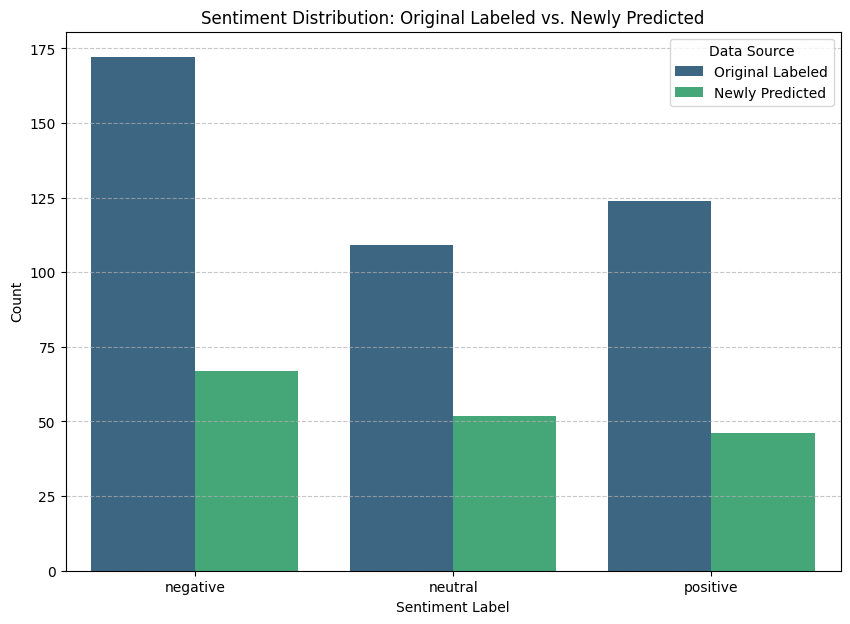

----------------------------------------

--- Generating Word Cloud from All Preprocessed Comments ---


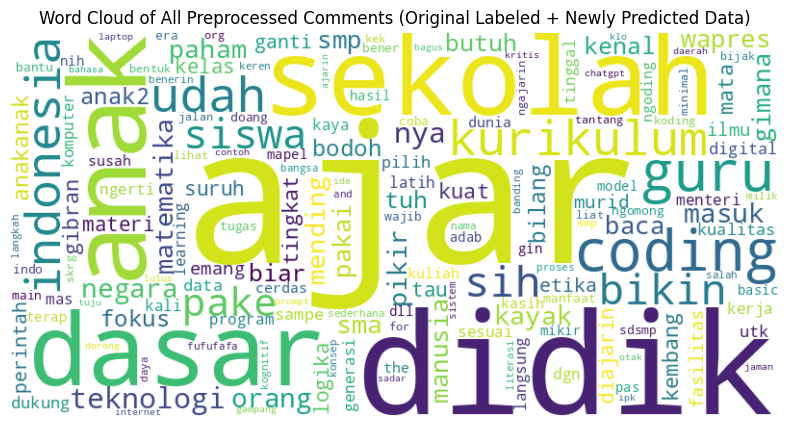

----------------------------------------

--- Showing Sample Comments for Each Predicted Sentiment from New Data ---

--- Sample 'negative' Predicted Comments ---
1. @IndoPopBase Ratain dulu kualitas sekolah di pelosok pastiin semuanya ada komputer, baru ngomong AI 
Tapi kepikiran sampe sini ga? Awkwkwkwk

Lagian kurikulum AI apa sih? Bikin prompt??? Tailah
2. untuk apa sebenarnya ? Untuk menyelesaikan soal matematika dasar ? Tidak semua orang mau anaknya bodoh seperti anda
3.  kalau mau masukin pelajaran AI untuk kelas sekolah umum (smu) dan  di SMK(kejuruan).

sekolah dasar =| cukup matematika pedoman dan pondasi dasar dr semua basis Teknologi . 
kalau sekedar pengenalan definisi diSMP.
4.  padahal dasar semua program Algorthm dan Jaringan AI mencangkup nilai dasar Matematika dan terusanya (Lain2nya).
kombinasi code(Software)/chip/server/sinkronisasi/Modal/etc. 
Wapresnya? berlebihan menyikapi Trend . 

lagian kalau sadar diri seharusnya enga usah nyapres
5. @IndoPopBase Belajar AI n

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory # Needed for preprocessing functions
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Ensure NLTK stopwords are downloaded (still needed for word cloud and preprocessing functions)
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
    print("NLTK stopwords downloaded.")

# --- Configuration for Column Names ---
text_column_name = 'komentar'
label_column_name = 'label' # For original labeled data

# --- Preprocessing Functions (ONLY if clean_text is not directly in CSVs) ---
# These functions are included as they are typically needed to generate 'clean_text'
# on the fly for the WordCloud, which relies on stemmed and cleaned text.
stop_words = set(stopwords.words('indonesian'))
stemmer = StemmerFactory().create_stemmer()

slang_dict = {
    'ga': 'tidak', 'gak': 'tidak', 'nggak': 'tidak', 'ngga': 'tidak',
    'banget': 'sangat', 'bgt': 'sangat', 'kalo': 'kalau', 'gitu': 'begitu',
    'aja': 'saja', 'loh': '', 'deh': '', 'mah': '', 'dah': '', 'cuy': '',
    'anj': 'kasar', 'wkwk': '', 'lol': '', 'btw': '', 'sm': 'sama',
    'pdhl': 'padahal', 'tp': 'tapi', 'sy': 'saya', 'gw': 'saya', 'gue': 'saya',
    'udh': 'sudah', 'sdh': 'sudah', 'dr': 'dari', 'tdk': 'tidak', 'td': 'tidak', 'tambah2':'tambah-tambah','gin':'gini','gmn':'gimana'
}

emoji_dict = {
    '😡':'negatif', '😢':'negatif', '😭':'negatif', '🤬':'negatif',
    '😍':'positif', '😊':'positif', '😂':'positif', '👍':'positif', '🙏':'positif'
}

sarcasm_markers = ['banget ya', 'hebat banget', 'ndasmu', 'pintar sekali ya']

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"(.)\1{2,}", r"\1", text)
    text = text.strip()
    return text

def preprocess(text):
    text = clean_text(text)
    for word, replacement in slang_dict.items():
        text = re.sub(r'\b' + re.escape(word) + r'\b', replacement, text)
    for emo, label in emoji_dict.items():
        text = text.replace(emo, label)
    tokens = text.split()
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words and len(t) > 2]
    for marker in sarcasm_markers:
        if marker in text:
            tokens.append("sarcasm")
    return ' '.join(tokens)


# --- 1. Load the Datasets ---
print("--- Loading Datasets for Analysis ---")
try:
    # Load original labeled data
    df_labeled = pd.read_csv('x-data-labeled.csv', sep=';', encoding='ISO-8859-1')
    df_labeled = df_labeled[['ï»¿komentar', 'label']].dropna()
    df_labeled = df_labeled.rename(columns={'ï»¿komentar': 'komentar'})
    df_labeled = df_labeled[df_labeled['label'].isin(['positive', 'negative', 'neutral'])]
    print(f"Loaded original labeled dataset with {len(df_labeled)} entries.")

    # Load new data (expecting 'predicted_label' column from previous prediction run)
    df_all_data = new_df
    print(f"Loaded new dataset with {len(df_all_data)} entries.")

    # Critical check: Ensure 'predicted_label' column exists
    if 'predicted_label' not in df_all_data.columns:
        raise KeyError("Error: 'predicted_label' column not found in 'x-data-all.csv'. Please ensure the prediction step has been run previously and saved predictions to this file.")

except FileNotFoundError:
    print("Error: Required CSV file not found. Please ensure 'x-data-labeled.csv' and 'x-data-all.csv' are uploaded.")
    print("Execution halted.")
    exit()
except KeyError as e:
    print(f"Error: {e}")
    print("Please ensure your CSVs have correct column names or that the prediction step was completed.")
    print("Execution halted.")
    exit()
except Exception as e:
    print(f"An error occurred during data loading: {e}")
    print("Execution halted.")
    exit()
print("-" * 40)


# --- 2. Apply Preprocessing to Both Datasets for Word Cloud and Consistency ---
# This creates the 'clean_text' column which is essential for the WordCloud.
print("\n--- Applying Custom Text Preprocessing to Both Datasets ---")
df_labeled['komentar'] = df_labeled['komentar'].astype(str).fillna('')
df_labeled['clean_text'] = df_labeled['komentar'].apply(preprocess)

df_all_data['komentar'] = df_all_data['komentar'].astype(str).fillna('')
df_all_data['clean_text'] = df_all_data['komentar'].apply(preprocess)

print("\nSample of preprocessed text from original labeled data (df_labeled['clean_text'].head()):")
print(df_labeled['clean_text'].head())
print("\nSample of preprocessed text from newly predicted data (df_all_data['clean_text'].head()):")
print(df_all_data['clean_text'].head())
print("-" * 40)


# --- 3. Prepare Data for Combined Distribution Plot ---
print("\n--- Preparing Data for Combined Distribution Plot ---")
# Create a temporary DataFrame for original labels
df_original_plot = df_labeled[['label']].copy()
df_original_plot.columns = ['Sentiment'] # Rename to a common column name
df_original_plot['Source'] = 'Original Labeled'

# Create a temporary DataFrame for predicted labels
df_predicted_plot = df_all_data[['predicted_label']].copy()
df_predicted_plot.columns = ['Sentiment'] # Rename to a common column name
df_predicted_plot['Source'] = 'Newly Predicted'

# Concatenate them for a single plot
df_combined_distribution = pd.concat([df_original_plot, df_predicted_plot])

print(f"Combined distribution DataFrame shape: {df_combined_distribution.shape}")
print(f"Sample of combined distribution data:\n{df_combined_distribution.head()}")
print("-" * 40)


# --- 4. Create Combined Distribution Diagram ---
print("\n--- Generating Combined Sentiment Distribution Diagram ---")
plt.figure(figsize=(10, 7))
sns.countplot(x='Sentiment', hue='Source', data=df_combined_distribution,
              order=['negative', 'neutral', 'positive'], palette='viridis') # Specify order for consistent plotting
plt.title('Sentiment Distribution: Original Labeled vs. Newly Predicted')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Data Source')
plt.show()
print("-" * 40)


# --- 5. Create Word Cloud from All Preprocessed Data (Labeled + Predicted) ---
print("\n--- Generating Word Cloud from All Preprocessed Comments ---")
# Combine clean_text from both dataframes for a comprehensive word cloud
all_cleaned_text_combined = ' '.join(
    df_labeled['clean_text'].dropna().tolist() + \
    df_all_data['clean_text'].dropna().tolist()
)

if all_cleaned_text_combined:
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          stopwords=stop_words,
                          collocations=False,
                          min_font_size=10).generate(all_cleaned_text_combined)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of All Preprocessed Comments (Original Labeled + Newly Predicted Data)')
    plt.show()
else:
    print("No text available to generate word cloud after preprocessing and dropping NA values from combined data.")
print("-" * 40)

# --- 6. Show Sample Comments for Each Predicted Sentiment from New Data ---
print("\n--- Showing Sample Comments for Each Predicted Sentiment from New Data ---")
unique_predicted_labels = df_all_data['predicted_label'].unique()

for label in unique_predicted_labels:
    print(f"\n--- Sample '{label}' Predicted Comments ---")
    sample_comments = df_all_data[df_all_data['predicted_label'] == label]['komentar'].head(5)
    if not sample_comments.empty:
        for i, comment in enumerate(sample_comments):
            print(f"{i+1}. {comment}")
    else:
        print(f"No comments predicted as '{label}' in the new dataset.")
print("\n--- Analysis Complete ---")



--- Preparing Data for Combined Distribution Plot (Sum of Counts) ---
Total sentiment counts:
  Sentiment  Count
0  negative    239
1   neutral    161
2  positive    170
----------------------------------------

--- Generating Combined Sentiment Distribution Diagram (Total Counts) ---


/tmp/ipython-input-14-3261256573.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='Count', data=df_total_sentiment_counts, palette='viridis')


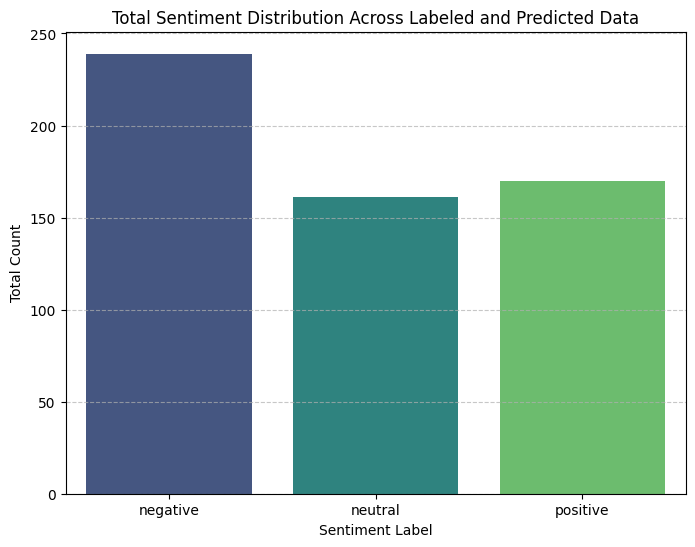

----------------------------------------


In [ ]:
# --- 3. Prepare Data for Combined Distribution Plot (Sum of Counts) ---
print("\n--- Preparing Data for Combined Distribution Plot (Sum of Counts) ---")
# Get counts from original labeled data
original_counts = df_labeled['label'].value_counts().reset_index()
original_counts.columns = ['Sentiment', 'Count']

# Get counts from newly predicted data
predicted_counts = df_all_data['predicted_label'].value_counts().reset_index()
predicted_counts.columns = ['Sentiment', 'Count']

# Combine and sum the counts
# This merges on 'Sentiment' and sums the 'Count' for each category
df_total_sentiment_counts = pd.concat([original_counts, predicted_counts]).groupby('Sentiment')['Count'].sum().reset_index()

# Define a consistent order for plotting
sentiment_order = ['negative', 'neutral', 'positive']
df_total_sentiment_counts['Sentiment'] = pd.Categorical(df_total_sentiment_counts['Sentiment'], categories=sentiment_order, ordered=True)
df_total_sentiment_counts = df_total_sentiment_counts.sort_values('Sentiment')

print(f"Total sentiment counts:\n{df_total_sentiment_counts}")
print("-" * 40)


# --- 4. Create Combined Distribution Diagram (Single Plot) ---
print("\n--- Generating Combined Sentiment Distribution Diagram (Total Counts) ---")
plt.figure(figsize=(8, 6))
sns.barplot(x='Sentiment', y='Count', data=df_total_sentiment_counts, palette='viridis')
plt.title('Total Sentiment Distribution Across Labeled and Predicted Data')
plt.xlabel('Sentiment Label')
plt.ylabel('Total Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("-" * 40)


--- Generating Predicted Label Distribution Diagram ---


/tmp/ipython-input-83-2069413147.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='predicted_label', data=new_df, order=new_df['predicted_label'].value_counts().index, palette='viridis')


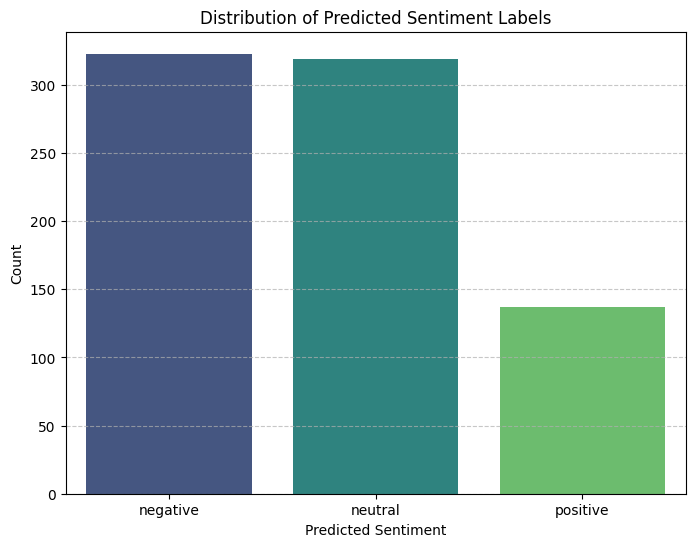

----------------------------------------


In [ ]:
# --- 5. Create Distribution Diagram of Predicted Labels ---
print("\n--- Generating Predicted Label Distribution Diagram ---")
plt.figure(figsize=(8, 6))
sns.countplot(x='predicted_label', data=new_df, order=new_df['predicted_label'].value_counts().index, palette='viridis')
plt.title('Distribution of Predicted Sentiment Labels')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("-" * 40)



--- Generating Word Cloud from All Preprocessed Text ---


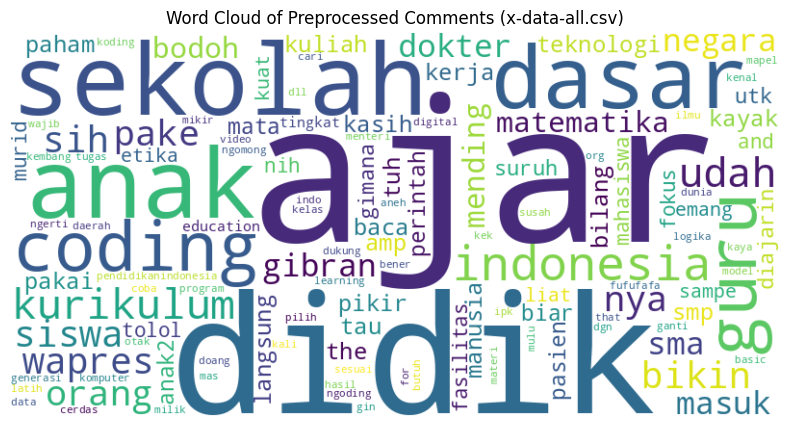


--- Visualizations Complete ---


In [ ]:
print("\n--- Generating Word Cloud from All Preprocessed Text ---")
# Join all preprocessed text into a single string for the word cloud
all_cleaned_text = ' '.join(new_df['clean_text'].dropna().tolist())

if all_cleaned_text:
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          stopwords=stop_words, # Using your Indonesian stopwords
                          collocations=False, # Set to False to avoid duplicates like "good good"
                          min_font_size=10).generate(all_cleaned_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Preprocessed Comments (x-data-all.csv)')
    plt.show()
else:
    print("No text available to generate word cloud after preprocessing and dropping NA values.")
print("\n--- Visualizations Complete ---")


In [ ]:
# --- 7. Show Sample Comments for Each Predicted Sentiment ---
print("\n--- Showing Sample Comments for Each Predicted Sentiment ---")
# Get unique predicted labels
unique_labels = new_df['predicted_label'].unique()

for label in unique_labels:
    print(f"\n--- Sample '{label}' Comments ---")
    # Filter DataFrame for the current label and display the original 'komentar'
    sample_comments = new_df[new_df['predicted_label'] == label]['komentar'].head(5) # Show first 5 samples
    if not sample_comments.empty:
        for i, comment in enumerate(sample_comments):
            print(f"{i+1}. {comment}")
    else:
        print(f"No comments predicted as '{label}'.")
print("\n--- Analysis Complete ---")


--- Showing Sample Comments for Each Predicted Sentiment ---

--- Sample 'negative' Comments ---
1. @Filosofi_Kucing @tempodotco Tambah2an anak SD kelas 1 masih banyak yang gak bisaaaâ¦ apalagi coding?

Dah lah benerin dulu kurikulum, sejahterakan pendidik, benerin tuh yang harus dibenerin, baru dah kalo semua beres usul coding masuk jadi matpel.

Kok nyocot tok tapi gak berbenah
2. @tempodotco Memang asli kosong  pohon dan buah. Berapalah biaya habis untuk pencitraan keluarga ini.?
3. @tempodotco Coba bilang.. gak usah banyak baca buku pelajaran.. banyakin baca Komik shincan aja.. toh Sy bisa jd org no 2.
4. @tempodotco anak sma belom pada lancar matematika dasar anak sd udah disuruh belajar koding koding, emang paling keren
5. @DSis48 bapak kau yg tolol. sampah

--- Sample 'neutral' Comments ---
1. @bunshin_ysf1 @tempodotco saya dari SMP bukan cuma hafal provinsi dan ibukota provinsi indo, tapi juga hafal 50 negara bagian dan ibukotanya di amrik
2. @tempodotco Senggel wae yo bran G